In [36]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zigzag import *
from IPython.display import display
import dataframe_image as dfi

In [37]:
#Data source: Yahoo Finance, S&P 500(^GSPC)
SP500 = pd.read_excel('S&P_Historical_Data\SP500.xlsx', index_col='Date')
SP500.set_index(pd.to_datetime(SP500.index, format='%b %d, %Y'),inplace=True)
SP500.drop(SP500.columns[[0,1,2,3,5]], axis = 1, inplace=True)
SP500.rename(columns={'Adj Close**':'Close'}, inplace=True)


7.693157894736841


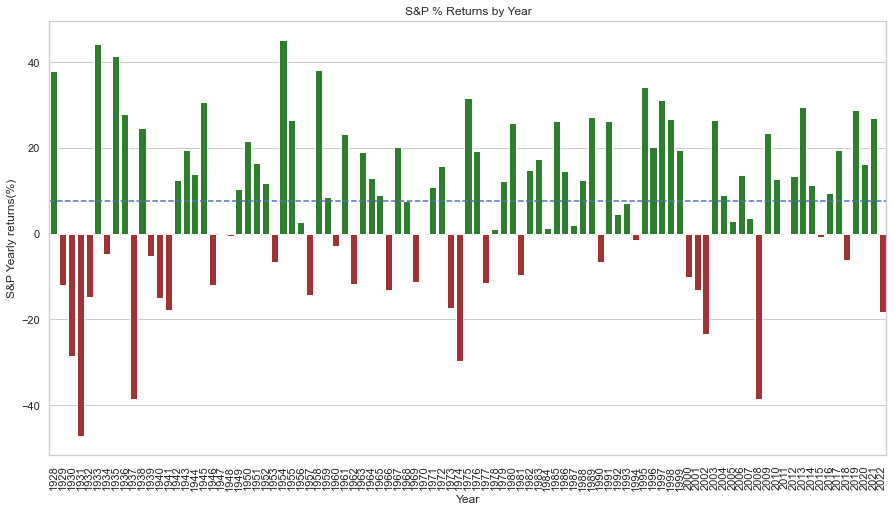

In [38]:
SP500_Yearly = SP500.resample("Y").last().dropna().iloc[::-1]
SP500_Yearly['Change %'] = ((SP500_Yearly['Close'] - SP500_Yearly['Close'].shift(-1) )/SP500_Yearly['Close'].shift(-1)*100).round(decimals=2)
SP500_Yearly = SP500_Yearly[:-1]
SP500_Yearly['Year'] = pd.DatetimeIndex(SP500_Yearly.index).year

sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")

colors = [1 if c >= 0 else 0 for c in SP500_Yearly['Change %']]

print(SP500_Yearly['Change %'].mean())

ax = sns.barplot(y='Change %', x='Year', hue=colors, palette=(SP500_Yearly['Change %'] > 0).map({True: "forestgreen", False: 'firebrick'}), data = SP500_Yearly, dodge=False).set(title='S&P % Returns by Year')
plt.ylabel('S&P Yearly returns(%)')
plt.axhline(y=SP500_Yearly['Change %'].mean(),linestyle='--')
plt.legend([],[], frameon=False)
plt.xticks(rotation=90)
#plt.show()
plt.savefig('images/S&P_Yearly_returns.png', bbox_inches='tight', facecolor='white')


If you got to this part of the code, let me confess one thing. I spend lots of time trying to figure out a way to get the market corrections algorithmically, I tried every library, logic or mathematical way I could and nothing worked reliably. Searching on forums for the solution, turns out I wasn't the first one to try it out and not the last one to give up on it. Market declines can come with different time frames and different amplitudes and require interpretation that is really hard to put into a formula, the only reason I kept trying to do it was programmer's pride. With the amount of data you have, just by looking at the chart you can identify every market decline in less than a day, and insert the data by hand, so that is what I did.

In [39]:
Declines = {
'Start Date':['1929-09-03','1930-04-10','1932-09-07','1933-07-18','1934-02-06','1936-04-06','1937-03-10','1938-10-10','1939-09-12','1940-11-12','1943-07-14','1946-01-29','1946-05-29',
'1947-02-11','1947-07-24','1948-06-15','1950-06-09','1953-01-05','1955-09-23','1956-03-20','1956-08-02','1957-07-15','1960-01-05','1960-08-24','1961-12-12','1962-08-22','1965-05-13',
'1966-02-09','1967-09-25','1968-11-29','1971-04-28','1971-09-08','1973-01-11','1974-11-07','1975-07-15','1976-09-21','1978-09-12','1979-10-05','1980-02-13','1980-11-28','1983-10-10',
'1987-08-25','1990-01-02','1990-07-16','1994-02-02','1997-02-18','1997-10-07','1998-07-17','1999-07-16','2000-03-24','2002-11-27','2004-02-11','2007-10-09','2010-04-23','2011-04-29',
'2011-10-28','2012-04-02','2015-05-21','2015-11-03','2018-01-26','2018-09-20','2020-02-19','2020-09-02','2022-01-03'],
'End Date':['1929-11-13','1932-06-01','1933-02-27','1933-10-19','1935-03-14','1936-04-29','1938-03-31','1939-04-11','1940-06-10','1942-04-28','1943-11-29','1946-02-26','1946-10-09',
'1947-05-20','1948-03-16','1949-06-13','1950-07-17','1953-09-14','1955-10-11','1956-05-28','1957-02-12','1957-10-22','1960-03-10','1960-10-25','1962-06-26','1962-10-23','1965-06-28',
'1966-10-07','1968-03-05','1970-05-26','1971-08-09','1971-11-23','1974-10-03','1974-12-06','1975-09-16','1978-03-06','1978-11-14','1979-11-07','1980-03-27','1982-08-12','1984-07-24',
'1987-12-04','1990-01-30','1990-10-11','1994-04-04','1997-04-11','1997-10-27','1998-08-31','1999-10-15','2002-10-09','2003-03-11','2004-08-12','2009-03-09','2010-07-02','2011-10-03',
'2011-11-25','2012-06-01','2015-08-25','2016-02-11','2018-02-08','2018-12-24','2020-03-23','2020-09-23','2022-06-16']}
Declines_df = pd.DataFrame(Declines,columns=['Start Date','End Date'])

Declines_df['Start Date'] = pd.to_datetime(Declines_df['Start Date'])
Declines_df['End Date'] = pd.to_datetime(Declines_df['End Date'])

Declines_df = Declines_df.merge(SP500, left_on='Start Date', right_on='Date', how="left")
Declines_df.rename(columns={'Close':'Start Close'}, inplace=True)

Declines_df = Declines_df.merge(SP500, left_on='End Date', right_on='Date', how="left")
Declines_df.rename(columns={'Close':'End Close'}, inplace=True)

Declines_df['% Difference'] = ((Declines_df['End Close'] - Declines_df['Start Close'] )/Declines_df['Start Close']*100).round(decimals=2)
Declines_df['Duration'] = (Declines_df['End Date'] - Declines_df['Start Date'])

for i in range(len(Declines_df)):
    try:
        Declines_df.loc[i,'Recovery Date'] = (SP500[(SP500.index > Declines_df['End Date'].iloc[i]) & (SP500.Close >= Declines_df['Start Close'].iloc[i])].sort_index()).index[0]
    except IndexError as error:
        print(error)

Declines_df['Recovery Duration'] = (Declines_df['Recovery Date'] - Declines_df['End Date'])

#display(Declines_df)
dfi.export(Declines_df, "images/All_declines.png")

index 0 is out of bounds for axis 0 with size 0


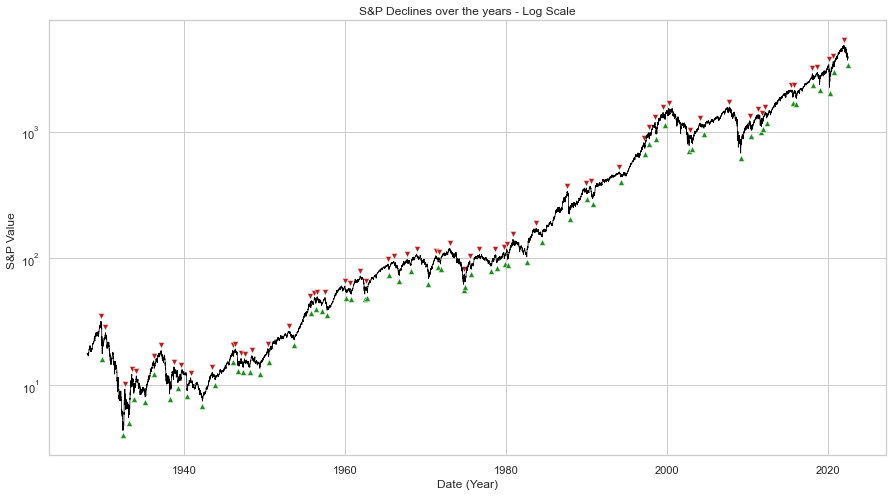

In [40]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")

higherPeaks = np.array(Declines_df['Start Close'])

ax = sns.lineplot(y=SP500['Close'], x=SP500.index, data = SP500, color='black', size=.5).set(title='S&P Declines over the years - Log Scale')
sns.scatterplot(y=Declines_df['Start Close']*1.1, x=Declines_df['Start Date'], data = Declines_df, color = 'firebrick', marker='v')
sns.scatterplot(y=Declines_df['End Close']/1.1, x=Declines_df['End Date'], data = Declines_df, color = 'forestgreen', marker='^' )

plt.xlabel('Date (Year)')
plt.ylabel('S&P Value ')
plt.yscale('log')
plt.legend([],[], frameon=False)
#plt.show()
plt.savefig('images/S&P_Declines_Overtime.png', bbox_inches='tight', facecolor='white')

In [58]:
Declines_near_10_df = Declines_df[(Declines_df['% Difference'] > -10) & (Declines_df['% Difference'] < -8)]
dfi.export(Declines_near_10_df, "images/Near_10_Declines.png")

Declines_10_20_df = Declines_df[(Declines_df['% Difference'] > -20) & (Declines_df['% Difference'] < -10)]
dfi.export(Declines_10_20_df, "images/10_20_Declines.png")

Declines_20_40_df = Declines_df[(Declines_df['% Difference'] > -40) & (Declines_df['% Difference'] < -20)]
dfi.export(Declines_20_40_df, "images/20_40_Declines.png")

Declines_40_df = Declines_df[(Declines_df['% Difference'] < -40)]
dfi.export(Declines_40_df, "images/40_Declines.png")

data = {'Declines (%)': ['~10%', '10% to 20%', '20% to 40%', '40%+'],
        'Number of declines': [len(Declines_near_10_df.index), len(Declines_10_20_df.index), len(Declines_20_40_df.index), len(Declines_40_df.index)],
        'Average decline %':[round(Declines_near_10_df['% Difference'].mean(),2),round(Declines_10_20_df['% Difference'].mean(),2),round(Declines_20_40_df['% Difference'].mean(),2),round(Declines_40_df['% Difference'].mean(),2)],
        'Average decline duration':[Declines_near_10_df['Duration'].mean(),Declines_10_20_df['Duration'].mean(),Declines_20_40_df['Duration'].mean(),Declines_40_df['Duration'].mean()],
        'Average recovery time':[Declines_near_10_df['Recovery Duration'].mean(),Declines_10_20_df['Recovery Duration'].mean(),Declines_20_40_df['Recovery Duration'].mean(),Declines_40_df['Recovery Duration'].mean()],
        'Average time between each decline':['-',(Declines_10_20_df['Start Date'] - Declines_10_20_df['Start Date'].shift(1)).mean(),(Declines_20_40_df['Start Date'] - Declines_20_40_df['Start Date'].shift(1)).mean(),(Declines_40_df['Start Date'] - Declines_40_df['Start Date'].shift(1)).mean()]}
 
# Create DataFrame
Declines_table = pd.DataFrame(data)
Declines_table['Average decline duration'] = Declines_table['Average decline duration'].dt.days
Declines_table['Average recovery time'] = Declines_table['Average recovery time'].dt.days
Declines_table['Average time between each decline'] = Declines_table['Average time between each decline'].dt.days
display(Declines_table)
dfi.export(Declines_table, "images/Declines_table.png")


,Declines (%),Number of declines,Average decline %,Average decline duration,Average recovery time,Average time between each decline
0,~10%,9,-9.49,60,88,0
1,10% to 20%,33,-13.68,105,152,941
2,20% to 40%,15,-28.30,265,633,2307
3,40%+,7,-53.82,498,3544,4754
